# TMDB Box Office Prediction

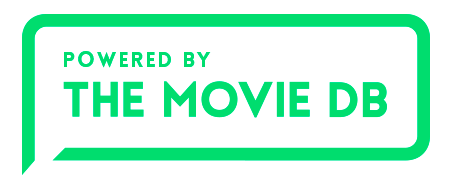

In [1]:
from IPython.display import Image
Image('pic.png')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code"></form>''')

# Data Description

In this dataset, there are 7398 movies and a variety of metadata obtained from The Movie Database [The Movie Database](https://www.themoviedb.org) (TMDB). Movies are labeled with id. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. We will predict the worldwide revenue for 4398 movies in the test file.

In [3]:
# import necessary tools
import pandas as pd
import numpy as np
import os
import seaborn as sns 
from scipy import stats
from scipy.stats import norm,skew
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import xgboost as xgb
import catboost as catb
import operator
import time
import ast
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

# Importing Data

In [4]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
# check data shape
print('Train test shape: ' + str(train.shape) + '\n' + 'Test set shape: ' + str(test.shape))

Train test shape: (3000, 23)
Test set shape: (4398, 22)


# Data Overview

First, we will check for corrupted/missing elements in data. Plot a horizontal bar graph for visualization.

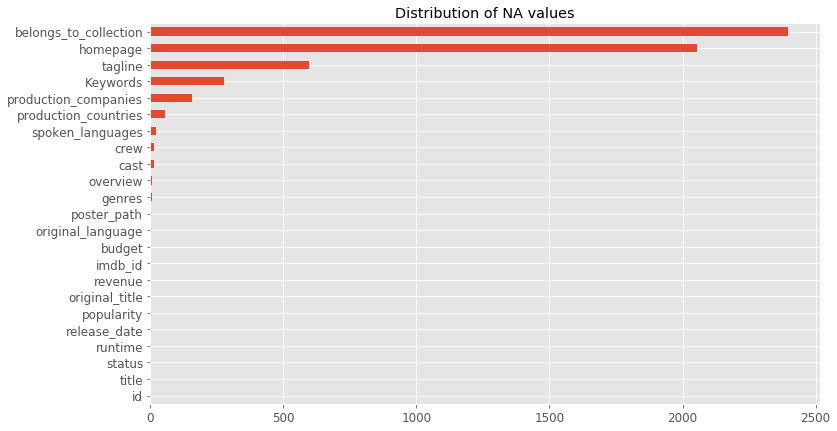

In [6]:
fig = plt.figure(figsize=(12, 7))
plt.title('Distribution of NA values')
train.isna().sum().sort_values(ascending=True).plot(kind='barh', fontsize=12)

In [7]:
train.dropna().shape

(203, 23)

In [8]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


# Exploratory Data Analysis

# Data Cleaning

First, we will manually deploy corrupted data using public info.

In [9]:
# train revenue and budget
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture

In [10]:
# test budget
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

In [11]:
# runtime
train.runtime[train.id == 391] = 86 #Il peor natagle de la meva vida
train.runtime[train.id == 592] = 90 #А поутру они проснулись
train.runtime[train.id == 925] = 95 #¿Quién mató a Bambi?
train.runtime[train.id == 978] = 93 #La peggior settimana della mia vita
train.runtime[train.id == 1256] = 92 #Cipolla Colt
train.runtime[train.id == 1542] = 93 #Все и сразу
train.runtime[train.id == 1875] = 86 #Vermist
train.runtime[train.id == 2151] = 108 #Mechenosets
train.runtime[train.id == 2499] = 108 #Na Igre 2. Novyy Uroven
train.runtime[train.id == 2646] = 98 #同桌的妳
train.runtime[train.id == 2786] = 111 #Revelation
train.runtime[train.id == 2866] = 96 #Tutto tutto niente niente

test.runtime[test.id == 4074] = 103 #Shikshanachya Aaicha Gho
test.runtime[test.id == 4222] = 93 #Street Knight
test.runtime[test.id == 4431] = 100 #Плюс один
test.runtime[test.id == 5520] = 86 #Glukhar v kino
test.runtime[test.id == 5845] = 83 #Frau Müller muss weg!
test.runtime[test.id == 5849] = 140 #Shabd
test.runtime[test.id == 6210] = 104 #Le dernier souffle
test.runtime[test.id == 6804] = 145 #Chaahat Ek Nasha..
test.runtime[test.id == 7321] = 87 #El truco del manco

Some movies have abnormally low revenue. Let's fix this.

In [12]:
power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

Take a look at the revenue distribution. We might need to do perform some data transformation.

In [13]:
def visualize_distribution(y):
    sns.distplot(y,fit=norm)
    mu,sigma=norm.fit(y)
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of revenue")
    plt.ylabel("Frequency")
    plt.show()
    
    
def visualize_probplot(y):
    stats.probplot(y,plot=plt)
    plt.show()

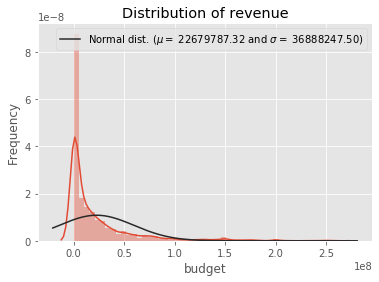

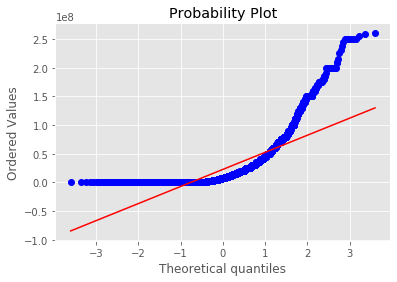

In [14]:
visualize_distribution(test.budget)
visualize_probplot(test.budget)

Apply log transformation:

In [15]:
train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])

train['popularity'] = np.log1p(train['popularity'])
test['popularity'] = np.log1p(test['popularity'])

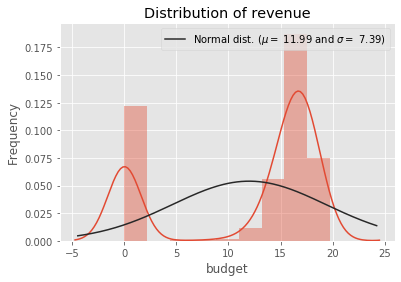

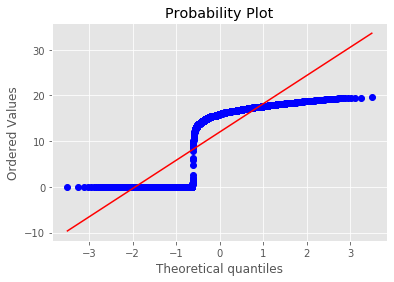

In [16]:
visualize_distribution(train.budget)
visualize_probplot(train.budget)

We will keep the original revenue until we apply models.

Let's drop useless features: imdb_id, poster_path.

In [17]:
train = train.drop(['imdb_id', 'poster_path'], axis = 1)
test = test.drop(['imdb_id', 'poster_path'], axis = 1)

# Feature Engineering

## Cast and Crew

In [18]:
train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"].apply(
    lambda x : ast.literal_eval(x))
train.loc[train["crew"].notnull(),"crew"]=train.loc[train["crew"].notnull(),"crew"].apply(
    lambda x : ast.literal_eval(x))

test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"].apply(
    lambda x : ast.literal_eval(x))
test.loc[test["crew"].notnull(),"crew"]=test.loc[test["crew"].notnull(),"crew"].apply(
    lambda x : ast.literal_eval(x))

In [19]:
train.loc[train["cast"].notnull(),"cast"]=train.loc[train["cast"].notnull(),"cast"].apply(
    lambda x : [y["name"] for y in x if y["order"]<6]) 

test.loc[test["cast"].notnull(),"cast"]=test.loc[test["cast"].notnull(),"cast"].apply(
    lambda x : [y["name"] for y in x if y["order"]<6]) 

## Director, Producer, Executive Producer 

In [20]:
def get_DirProdExP(df):
    df["Director"]=[[] for i in range(df.shape[0])]
    df["Producer"]=[[] for i in range(df.shape[0])]
    df["Executive Producer"]=[[] for i in range(df.shape[0])]

    df["Director"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])

    df["Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])

    df["Executive Producer"]=df.loc[df["crew"].notnull(),"crew"]\
    .apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])
    
    return df

In [21]:
# apply to both dataset
train = get_DirProdExP(train)
test = get_DirProdExP(test)

Let's look at the numbers:

In [22]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3000.000000,3.000000e+03,3000.000000,3.000000e+03
mean,1500.500000,11.985069,1.975396e+00,108.250000,6.672403e+07
std,866.169729,7.394925,7.416869e-01,21.016059,1.374992e+08
min,1.000000,0.000000,9.999995e-07,11.000000,1.000000e+00
25%,750.750000,0.000000,1.613042e+00,94.000000,2.447642e+06
50%,1500.500000,15.894952,2.125233e+00,104.000000,1.692863e+07
75%,2250.250000,17.216708,2.475780e+00,118.000000,6.877599e+07
max,3000.000000,19.755682,5.688117e+00,338.000000,1.519558e+09


How many missing values are there?

In [23]:
print ('budget: ' + str(sum(train['budget'].isna())) + ', popularity: ' + str(sum(train['popularity'].isna())) + 
      ', runtime: ' + str(sum(train['runtime'].isna())) + ', revenue: ' + str(sum(train['revenue'].isna())))

budget: 0, popularity: 0, runtime: 0, revenue: 0


In [24]:
# drop the missing values
f = ['budget', 'popularity', 'runtime', 'revenue']
train[f].dropna(inplace=True)

Let's generate some pairplots to observe the distribution of data from one feature to the other using Seaborn's scatter matrix:

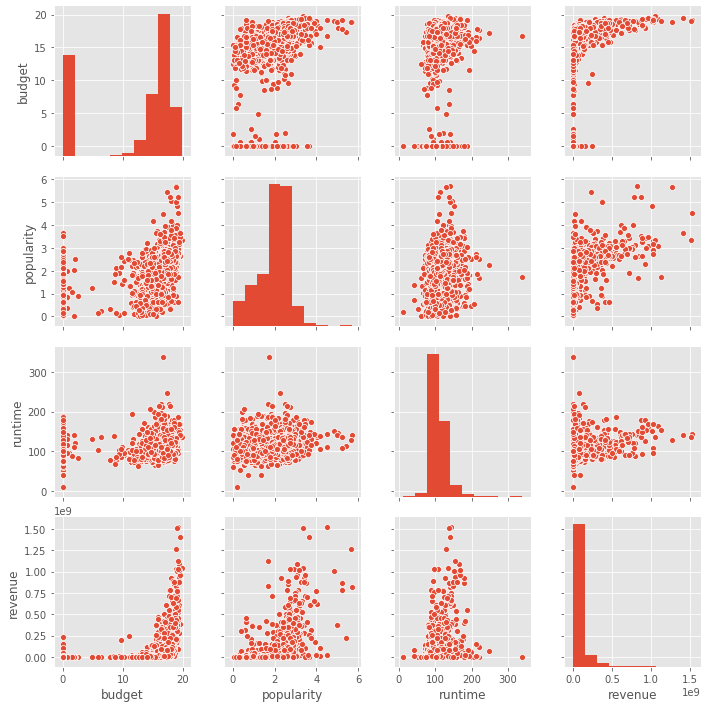

In [25]:
sns.pairplot(train[f])

At first look, budget and revenue seem to have strong correlation.

## Language

The spoken_languages column contains a list of dictionaries. Reformat it and print the result:

In [26]:
train['spoken_languages'] = train['spoken_languages'].apply(lambda x: list(map(
    lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test['spoken_languages'] = test['spoken_languages'].apply(
    lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

train['spoken_languages'].head()

0        [en]
1        [en]
2        [en]
3    [en, hi]
4        [ko]
Name: spoken_languages, dtype: object

Let's create two additional features: the number of spoken languages, and whether there is English in it or not.

In [27]:
train['nb_spoken_languages'] = train.spoken_languages.apply(len)
test['nb_spoken_languages'] = test.spoken_languages.apply(len)

train['english_spoken'] = train.spoken_languages.apply(lambda x: 'en' in x)
test['english_spoken'] = test.spoken_languages.apply(lambda x: 'en' in x)

We will plot a bar graph representing the distribution of each number of spoken languages:

In [28]:
train['nb_spoken_languages'].value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: nb_spoken_languages, dtype: int64

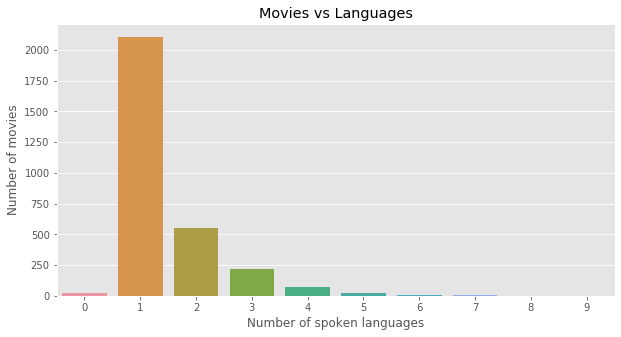

In [29]:
# plot a bar graph
plt.figure(figsize=(10,5))
sns.barplot(train['nb_spoken_languages'].value_counts().index, train['nb_spoken_languages'].value_counts().values, 
            alpha=1)
plt.title('Movies vs Languages')
plt.ylabel('Number of movies', fontsize=12)
plt.xlabel('Number of spoken languages', fontsize=12)
plt.show()

As expected, most movies only have 1-2 spoken languages. However, there is one outlier with NINE spoken languages in that movie!

## Original Language

Let's see what are the main original languages in both the testing and training data:

In [30]:
all_languages = pd.concat([train.original_language, test.original_language], axis=0).value_counts()
all_languages[all_languages > 10]

en    6351
fr     199
hi     118
ru     109
es      95
ja      90
it      56
de      49
ko      49
zh      46
cn      41
ta      31
sv      20
da      17
pt      13
ml      12
nl      11
Name: original_language, dtype: int64

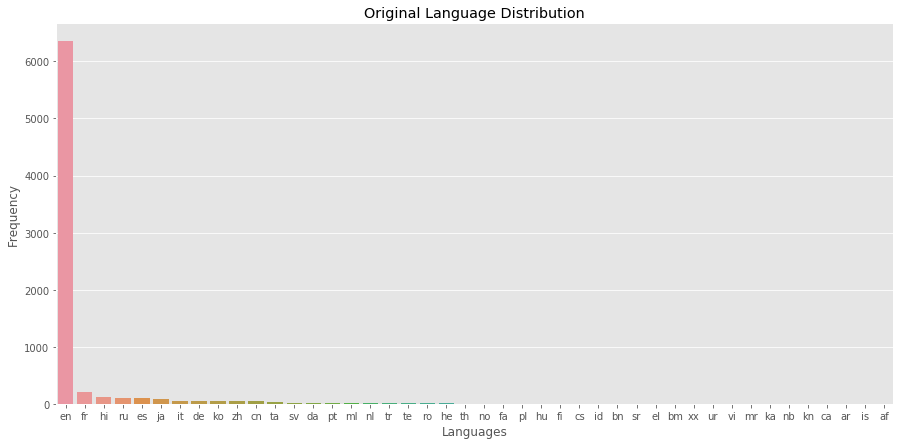

In [31]:
plt.figure(figsize=(15, 7))
sns.barplot(all_languages.index, all_languages.values, alpha=1)
plt.title('Original Language Distribution')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Languages', fontsize=12)
plt.show()

We then will make a main_languages list, categorize the languages, add an "other" category, keep only the languages that are on main_languages, and finally put languages to numeric according to the indexes of the dictionary.

In [32]:
# the main languages
main_languages = list(all_languages[all_languages>20].index)
# categorize them, and add an 'other' category
dict_language = dict(zip(main_languages, range(1, len(main_languages)+1)))
dict_language['other'] = 0

# keep only the languages that are on main_languages
train.original_language = train.original_language.apply(lambda x: x if x in main_languages else 'other')
test.original_language = test.original_language.apply(lambda x: x if x in main_languages else 'other')

# put languages to numeric according to the indexes of the dictionary
train['language'] = train.original_language.apply(lambda x: dict_language[x])
test['language'] = test.original_language.apply(lambda x: dict_language[x])

## Movie Genre

Let's look at the different genres associated with the movies.

In [33]:
# Apply the same preprocessing on the string values
train.genres = train.genres.apply(lambda x: list(map(
    lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.genres = test.genres.apply(
    lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

train.genres.head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres, dtype: object

Then we check the distribution of the number of genres per movie:

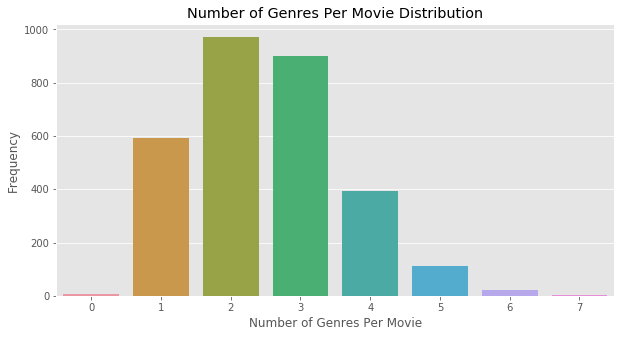

In [34]:
plt.figure(figsize=(10, 5))
sns.barplot(train.genres.apply(len).value_counts().sort_index().keys(), 
            train.genres.apply(len).value_counts().sort_index(), alpha=1)
plt.title('Number of Genres Per Movie Distribution')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Number of Genres Per Movie', fontsize=12)
plt.show()

There are 3 movies with 7 genres!

In [35]:
for v in train[train.genres.apply(len)==7][['title', 'genres']].values:
    print('film:', v[0], '\ngenres:', *v[1], '\n')

film: Jimmy Neutron: Boy Genius 
genres: Action Adventure Animation Comedy Family Fantasy Science Fiction 

film: Fishtales 
genres: Fantasy Drama Comedy Science Fiction Romance Family Foreign 

film: Crossroads 
genres: Action Adventure Comedy Drama Family Music Romance 



Let's check the distribution of genres:

In [36]:
genres = Counter(itertools.chain.from_iterable(pd.concat((train.genres, test.genres), axis=0).values))
genres

Counter({'Comedy': 2605,
         'Drama': 3676,
         'Family': 675,
         'Romance': 1435,
         'Thriller': 1869,
         'Action': 1735,
         'Animation': 382,
         'Adventure': 1116,
         'Horror': 735,
         'Documentary': 221,
         'Music': 267,
         'Crime': 1084,
         'Science Fiction': 744,
         'Mystery': 550,
         'Foreign': 84,
         'Fantasy': 628,
         'War': 243,
         'Western': 117,
         'History': 295,
         'TV Movie': 1})

In [37]:
type(genres)

collections.Counter

So now we have 20 categorical features in the genre column. Let's apply dimensional reduction to reduce the number of features of genre to 3 using SVD.

In [38]:
temp_train = train[['id', 'genres']]
temp_test = test[['id', 'genres']]

for g in genres:
    temp_train[g] = temp_train.genres.apply(lambda x, g=g: 1 if g in x else 0)
    temp_test[g] = temp_test.genres.apply(lambda x, g=g: 1 if g in x else 0)
    
X_train = temp_train.drop(['genres', 'id'], axis=1).values
X_test = temp_test.drop(['genres', 'id'], axis=1).values

# Number of features we want for genres
n_comp_genres = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_genres),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

In [39]:
temp_train.head()

,id,genres,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,...,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,1,[Comedy],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,"[Comedy, Drama, Family, Romance]",1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,[Drama],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,"[Thriller, Drama]",0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,"[Action, Thriller]",0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
my_genres = [g for g in genres if g != 'TV Movie']

train = pd.concat([train, temp_train.iloc[:,1:]], axis=1) 
train.drop(train.columns[-1],axis=1, inplace = True)

test = pd.concat([test, temp_test.iloc[:,1:]], axis=1) 
test.drop(test.columns[-1], axis=1, inplace = True)

In [41]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,original_language,original_title,overview,popularity,production_companies,...,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",16.454568,[Comedy],NaN,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",2.024905,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",...,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",17.504390,"[Comedy, Drama, Family, Romance]",NaN,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,2.224504,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,0,0,0,0,0,0,0,0,0,0
2,3,NaN,15.009433,[Drama],http://sonyclassics.com/whiplash/,en,Whiplash,"Under the direction of a ruthless instructor, ...",4.178992,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",...,0,0,0,0,0,0,0,0,0,0
3,4,NaN,13.997833,"[Thriller, Drama]",http://kahaanithefilm.com/,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,1.429099,NaN,...,0,0,0,0,0,0,0,0,0,0
4,5,NaN,0.000000,"[Action, Thriller]",NaN,ko,마린보이,Marine Boy is the story of a former national s...,0.764570,NaN,...,0,0,0,0,0,0,0,0,0,0


## Keywords

In [42]:
train.Keywords = train.Keywords.apply(lambda x: list(map(
    lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))
test.Keywords = test.Keywords.apply(
    lambda x: list(map(lambda d: list(d.values())[1], ast.literal_eval(x)) if isinstance(x, str) else []))

train['nb_keywords'] = train.Keywords.apply(len)
test['nb_keywords'] = test.Keywords.apply(len)

train.Keywords.head()

0    [time travel, sequel, hot tub, duringcreditsst...
1        [coronation, duty, marriage, falling in love]
2    [jazz, obsession, conservatory, music teacher,...
3    [mystery, bollywood, police corruption, crime,...
4                                                   []
Name: Keywords, dtype: object

## production_companies

In [43]:
train.production_companies = train.production_companies.apply(lambda x: list(map(
    lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_companies = test.production_companies.apply(
    lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

In [44]:
production_companies = Counter(itertools.chain.from_iterable(
    pd.concat((train.production_companies, test.production_companies), axis=0).values))
print("Number of different production companies:", len(production_companies))

Number of different production companies: 7087


In [45]:
train['nb_production_companies'] = train.production_companies.apply(len)
test['nb_production_companies'] = test.production_companies.apply(len)

Just like what we did to the genres column, we will apply SVD to Production_companies:

In [46]:
print('Applying SVD on production companies to create reduced features')

# Factorizing all the little production companies into an 'other' variable
big_companies = [p for p in production_companies if production_companies[p] > 30]
train.production_companies = train.production_companies.apply(lambda l: list(map(lambda x: x if x in big_companies else 'other', l)))

temp_train = train[['id', 'production_companies']]
temp_test = test[['id', 'production_companies']]

for p in big_companies + ['other']:
    temp_train[p] = temp_train.production_companies.apply(lambda x: 1 if p in x else 0)
    temp_test[p] = temp_test.production_companies.apply(lambda x: 1 if p in x else 0)
    
X_train = temp_train.drop(['production_companies', 'id'], axis=1).values
X_test = temp_test.drop(['production_companies', 'id'], axis=1).values

# Number of features we want for genres
n_comp_production_companies = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_production_companies),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

for i in range(n_comp_production_companies):
    train['production_companies_reduced_{}'.format(i)] = f_train[:, i]
    test['production_companies_reduced_{}'.format(i)] = f_test[:, i]

Applying SVD on production companies to create reduced features


In [47]:
train[['production_companies_reduced_0', 'production_companies_reduced_1', 'production_companies_reduced_2']].head(3)

,production_companies_reduced_0,production_companies_reduced_1,production_companies_reduced_2
0,0.284467,-0.270501,-0.919732
1,0.617957,-0.298804,-0.727217
2,0.998022,-0.041327,-0.047372


## production_countries

In [48]:
train.production_countries = train.production_countries.apply(lambda x: list(map(
    lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))
test.production_countries = test.production_countries.apply(
    lambda x: list(map(lambda d: list(d.values())[0], ast.literal_eval(x)) if isinstance(x, str) else []))

In [49]:
production_countries = Counter(itertools.chain.from_iterable(pd.concat((train.production_countries, test.production_countries), axis=0).values))
print("Number of different production companies:", len(production_countries))

Number of different production companies: 98


In [50]:
print('Applying SVD on production countries to create reduced features')

# Factorizing all the little production companies into an 'other' variable
big_countries = [p for p in production_countries if production_countries[p] > 30]
train.production_countries = train.production_countries.apply(lambda l: list(map(lambda x: x if x in big_countries else 'other', l)))

temp_train = train[['id', 'production_countries']]
temp_test = test[['id', 'production_countries']]

for p in big_countries + ['other']:
    temp_train[p] = temp_train.production_countries.apply(lambda x: 1 if p in x else 0)
    temp_test[p] = temp_test.production_countries.apply(lambda x: 1 if p in x else 0)
    
X_train = temp_train.drop(['production_countries', 'id'], axis=1).values
X_test = temp_test.drop(['production_countries', 'id'], axis=1).values

# Number of features we want for genres
n_comp_production_countries = 3

# Build the SVD pipeline
svd = make_pipeline(
    TruncatedSVD(n_components=n_comp_production_countries),
    Normalizer(norm='l2', copy=False)
)

# Here are our new features
f_train = svd.fit_transform(X_train)
f_test = svd.transform(X_test)

for i in range(n_comp_production_countries):
    train['production_countries_reduced_{}'.format(i)] = f_train[:, i]
    test['production_countries_reduced_{}'.format(i)] = f_test[:, i]

Applying SVD on production countries to create reduced features


In [51]:
train[['production_countries_reduced_0', 'production_countries_reduced_1', 'production_countries_reduced_2']].head(3)

,production_countries_reduced_0,production_countries_reduced_1,production_countries_reduced_2
0,0.990581,-0.1362,-0.014073
1,0.990581,-0.1362,-0.014073
2,0.990581,-0.1362,-0.014073


## Release Date

We will perform data cleaning on this feature. 

In [52]:
test.loc[test.release_date.isna(), 'release_date'] = '05/01/00'

In [53]:
# train
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
train['Year'] = train.release_date.dt.year
train['Month'] = train.release_date.dt.month
train['Day'] = train.release_date.dt.day
train['dayofweek'] = train.release_date.dt.dayofweek 
train['quarter'] = train.release_date.dt.quarter   
# test
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')
test['Year'] = test.release_date.dt.year
test['Month'] = test.release_date.dt.month
test['Day'] = test.release_date.dt.day
test['dayofweek'] = test.release_date.dt.dayofweek 
test['quarter'] = test.release_date.dt.quarter  

### Dummy Month

In [54]:
dummies = pd.get_dummies(train['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(x))
dummies2 = pd.get_dummies(test['Month'] ,drop_first=True).rename(columns=lambda x: 'Month' + str(int(x)))
train = pd.concat([train, dummies], axis=1)
test = pd.concat([test, dummies2], axis = 1)

### Dummy DayofWeek

In [55]:
ddow = pd.get_dummies(train['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(x))
ddow2 = pd.get_dummies(test['dayofweek'] ,drop_first=True).rename(columns=lambda x: 'dayofweek' + str(int(x)))
train = pd.concat([train, ddow], axis=1)
test = pd.concat([test, ddow2], axis = 1)

### Years

In [56]:
print ('Year max in train set: ' + str(max(train.Year)) + ',' + ' Year max in test set: ' + str(max(test.Year)))

Year max in train set: 2068, Year max in test set: 2068


There is something wrong with the year feature: the year max should be 2018, not 2068. It seems that all the year dates that are higher than 2018 should be 19XX instead. We will fix this.

In [57]:
train.loc[train['Year'] > 2018, 'Year'] = train.loc[train['Year'] > 2018, 'Year'].apply(lambda x: x - 100)
test.loc[test['Year'] > 2018, 'Year'] = test.loc[test['Year'] > 2018, 'Year'].apply(lambda x: x - 100)

In [58]:
test.Year.describe()

count    4398.000000
mean     1999.675307
std        15.286695
min      1922.000000
25%      1992.000000
50%      2004.000000
75%      2011.000000
max      2018.000000
Name: Year, dtype: float64

Looks good, doesn't it?

### Year Distribution

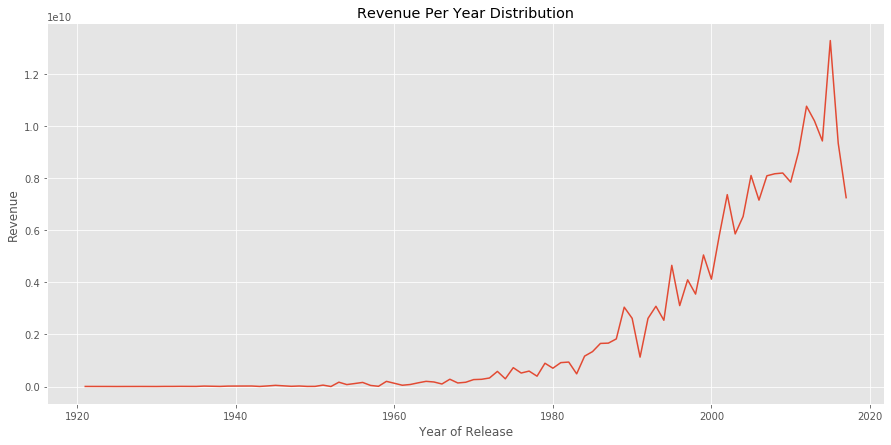

In [59]:
data_plot = train[['revenue', 'Year']]
money_Y = data_plot.groupby('Year')['revenue'].sum()

plt.figure(figsize=(15, 7))
sns.lineplot(data=money_Y, alpha=1)
plt.title('Revenue Per Year Distribution')
plt.ylabel('Revenue', fontsize=12)
plt.xlabel('Year of Release', fontsize=12)
plt.show()

### Month Distribution

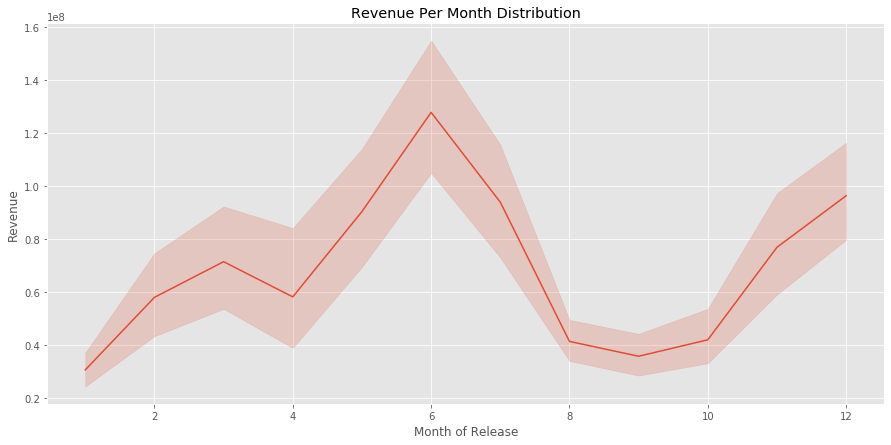

In [60]:
plt.figure(figsize=(15, 7))
sns.lineplot(train.Month, train.revenue, alpha=1)
plt.title('Revenue Per Month Distribution')
plt.ylabel('Revenue', fontsize=12)
plt.xlabel('Month of Release', fontsize=12)
plt.show()

June seems to be the golden time of the year to release movie. Apparently, most blockbusters in our recent memory were released in the summer: Guardians of the Galaxy Vol. 2, Spider-Man: Homecoming, Wonder Woman, etc.

### Day of Week Distribution

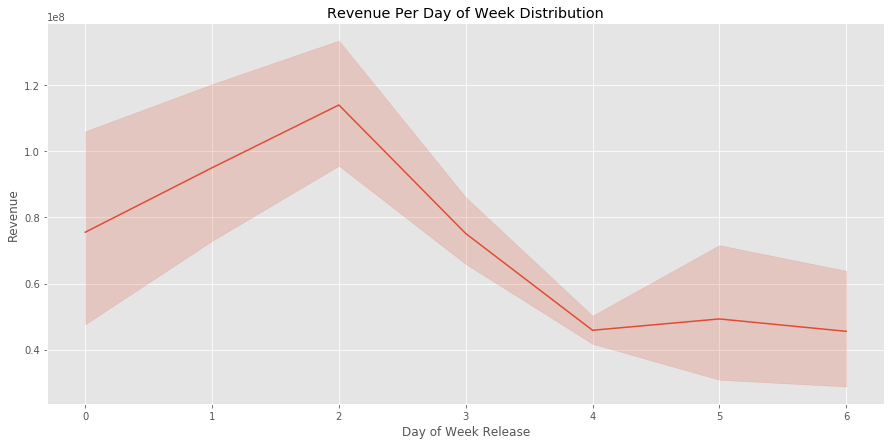

In [61]:
plt.figure(figsize=(15, 7))
sns.lineplot(train.dayofweek, train.revenue, alpha=1)
plt.title('Revenue Per Day of Week Distribution')
plt.ylabel('Revenue', fontsize=12)
plt.xlabel('Day of Week Release', fontsize=12)
plt.show()

As you can see, most movies are released on Monday, Tuesday, and Wednesday. There is a clear downward trend in terms of revenue for movies that were released after Wednesday during the release week.

## Lazzy Features

There are movies which budget is listed as 0. We will replace those missing values with the median to avoid outliers.

In [62]:
def lazzy_feat(df):
    
    df['Ratiobudgetbypopularity'] = df['budget']/df['popularity']
    df['RatiopopularitybyYear'] = df['popularity']/df['Year']
    df['RatoioruntimebyYear'] = df['runtime']/df['Year']
    
    
    df['budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['budget_Year_ratio'] = df['budget']/df['Year']
    
    return df

train = lazzy_feat(train)
test = lazzy_feat(test)

For categorical features that have missing values like 'homepage' or 'collection', we will add additional columns for those, e.g, 'has_homepage' and fix strange occurrences.

In [63]:
train['has_homepage'] = np.where(train['homepage'].isna(), 0, 1)
train ['has_collection'] = np.where(train['belongs_to_collection'].isna(), 0, 1)

test['has_homepage'] = np.where(test['homepage'].isna(), 0, 1)
test ['has_collection'] = np.where(test['belongs_to_collection'].isna(), 0, 1)

train['has_tagline'] = np.where (train['tagline'].isna(), 0, 1)
test['has_tagline'] = np.where (test['tagline'].isna(), 0, 1)

train['title_different'] = np.where(train['original_title'] == train['title'], 0, 1)
test['title_different'] = np.where(test['original_title'] == test['title'], 0, 1)

train['isReleased'] = np.where(train['status'] != 'Released', 0, 1)
test['isReleased'] = np.where(test['status'] != 'Released', 0, 1)

Finally, let's string related features together.

In [64]:
features = ['budget', 
            'popularity', 
            'runtime', 
            'nb_spoken_languages', 
            'nb_production_companies',
            'english_spoken', 
            'language',
            'has_homepage', 'has_collection', 'isReleased', 'has_tagline', 'title_different',
            'Day',
            'quarter', 'Year',
            'nb_keywords', 
            'Month2', 'Month3',  'Month4', 'Month5',  'Month6', 'Month7',
            'Ratiobudgetbypopularity', 'RatiopopularitybyYear',
            'RatoioruntimebyYear', 'budget_runtime_ratio', 'budget_Year_ratio',
            'Month8', 'Month9',  'Month10', 'Month11', 'Month12']

features += [col for col in train.columns if 'dayofweek' in col and col != "dayofweek"]
features += my_genres
features += ['production_companies_reduced_{}'.format(i) for i in range(n_comp_production_companies)]
features += ['production_countries_reduced_{}'.format(i) for i in range(n_comp_production_countries)]
X = train[features]
X['revenue'] = train.revenue

X.columns

Index(['budget', 'popularity', 'runtime', 'nb_spoken_languages',
       'nb_production_companies', 'english_spoken', 'language', 'has_homepage',
       'has_collection', 'isReleased', 'has_tagline', 'title_different', 'Day',
       'quarter', 'Year', 'nb_keywords', 'Month2', 'Month3', 'Month4',
       'Month5', 'Month6', 'Month7', 'Ratiobudgetbypopularity',
       'RatiopopularitybyYear', 'RatoioruntimebyYear', 'budget_runtime_ratio',
       'budget_Year_ratio', 'Month8', 'Month9', 'Month10', 'Month11',
       'Month12', 'dayofweek1', 'dayofweek2', 'dayofweek3', 'dayofweek4',
       'dayofweek5', 'dayofweek6', 'Comedy', 'Drama', 'Family', 'Romance',
       'Thriller', 'Action', 'Animation', 'Adventure', 'Horror', 'Documentary',
       'Music', 'Crime', 'Science Fiction', 'Mystery', 'Foreign', 'Fantasy',
       'War', 'Western', 'History', 'production_companies_reduced_0',
       'production_companies_reduced_1', 'production_companies_reduced_2',
       'production_countries_reduced_0',

We're finally done with data wrangling! Let's make a heatmap to check correlations before proceeding into making Machine Learning models.

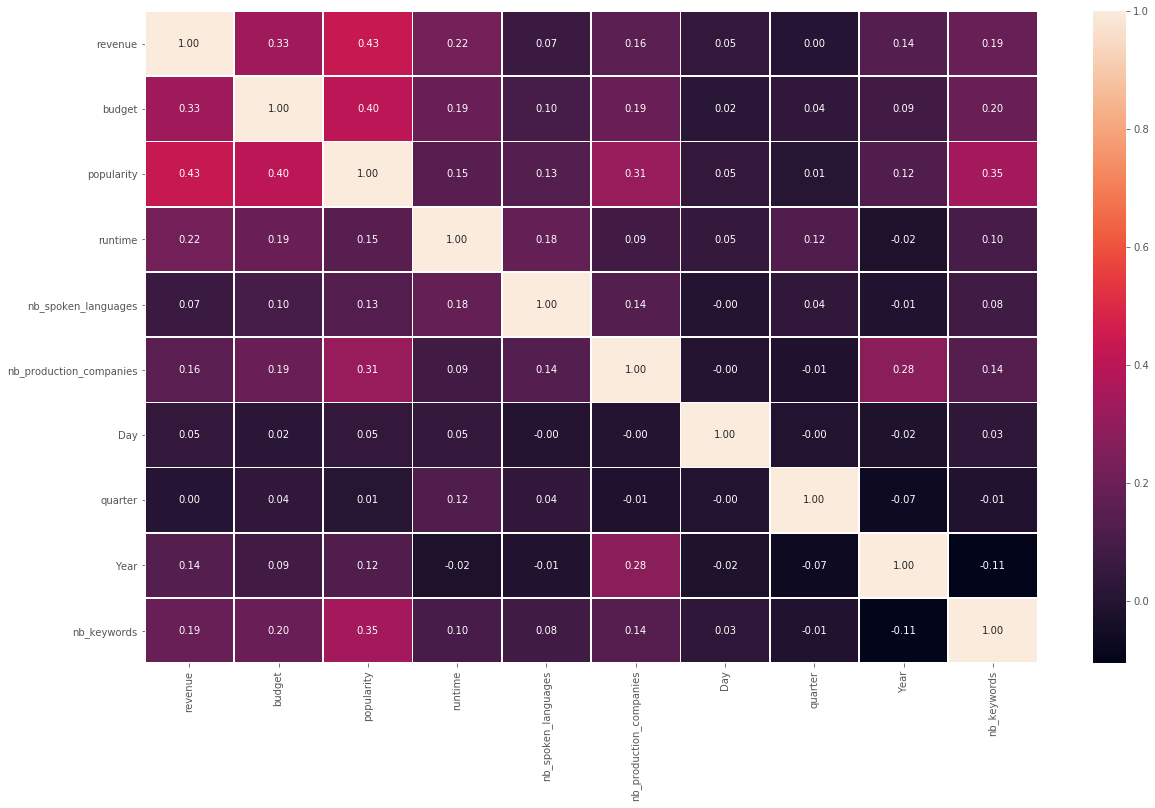

In [65]:
cor_features = X[['revenue', 'budget',  'popularity', 'runtime', 'nb_spoken_languages', 'nb_production_companies',
            'Day', 'quarter', 'Year','nb_keywords' ]]
f,ax = plt.subplots(figsize=(20, 12))
sns.heatmap(cor_features.corr(), annot=True, linewidths=.7, fmt= '.2f',ax=ax)
plt.show()

### Takeaway from the Plots

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. 

# Model Building

## Split Data into Training and Testing set

In [66]:
X = X.drop(['revenue'], axis = 1)
y = train.revenue.apply(np.log1p)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

In [67]:
print('Training set size: ', X_train.shape, '\n','Test set size:', X_test.shape)

Training set size:  (2400, 63) 
 Test set size: (600, 63)


We are building two ML models for prediction: XGBoost and CatBoost. After getting predictions from said models, we will apply ensemble by simply taking weighted average of the results.

# Simple Stacking Approach: Averaging Base Model

We begin ensemble learning with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse.

In [69]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import catboost as catb
import lightgbm as lgb

In [70]:
# this Python script is from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [71]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=12).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base LightGBM

In [72]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [73]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 1.9079 (0.0743)



## Base Model XGBoost

In [76]:
xgb_model_full = xgb.XGBRegressor(objective  = 'reg:linear', 
          eta = 0.01, 
          max_depth = 6,
          min_child_weight = 3,
          subsample = 0.8, 
          colsample_bytree = 0.8,
          colsample_bylevel = 0.50, 
          gamma = 1.45, 
          eval_metric = 'rmse',
          seed = 12, n_estimators = 2000)

In [77]:
score = rmsle_cv(xgb_model_full)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[00:24:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost score: 1.9469 (0.0869)



## Stacking Models

Finally, we average baseline models:

In [78]:
averaged_models = AveragingModels(models = (model_lgb, xgb_model_full))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[00:26:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Averaged base models score: 1.8964 (0.0796)



Wow! It seems stacking really did improve the score (from ~1.94 to 1.89).